In [72]:
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
df = pd.read_csv("USD_PLN Historical Data_Backtrade.csv")

In [74]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [75]:
df.rename(columns={"Price": "close"}, inplace=True)


In [76]:
df.columns

Index(['Date', 'close', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [77]:
# Sprawdzenie, czy w kolumnach występują wartości NaN
nan_columns = df.columns[df.isna().any()].tolist()

if nan_columns:
    print(f"Kolumny zawierające wartości NaN: {', '.join(nan_columns)}")
else:
    print("Nie ma kolumn zawierających wartości NaN.")

Kolumny zawierające wartości NaN: Vol.


In [78]:
df['Vol.'] = df['Vol.'].fillna(0)

In [79]:
print(df['close'].isnull().sum())


0


In [80]:
# Sprawdzenie danych
print(df.describe())  # Wyświetli podstawowe statystyki dla każdej kolumny
print("\nCzy są jakieś NaN w danych?:", df.isnull().any().any())

            close        Open        High         Low   Vol.
count  176.000000  176.000000  176.000000  176.000000  176.0
mean     4.218465    4.222795    4.245548    4.200260    0.0
std      0.147300    0.147641    0.148708    0.146054    0.0
min      3.950500    3.954400    3.967600    3.935200    0.0
25%      4.102650    4.104975    4.124025    4.076750    0.0
50%      4.192600    4.195950    4.211450    4.170450    0.0
75%      4.345925    4.356975    4.373000    4.323150    0.0
max      4.477700    4.481000    4.503300    4.459800    0.0

Czy są jakieś NaN w danych?: False


<IPython.core.display.Javascript object>

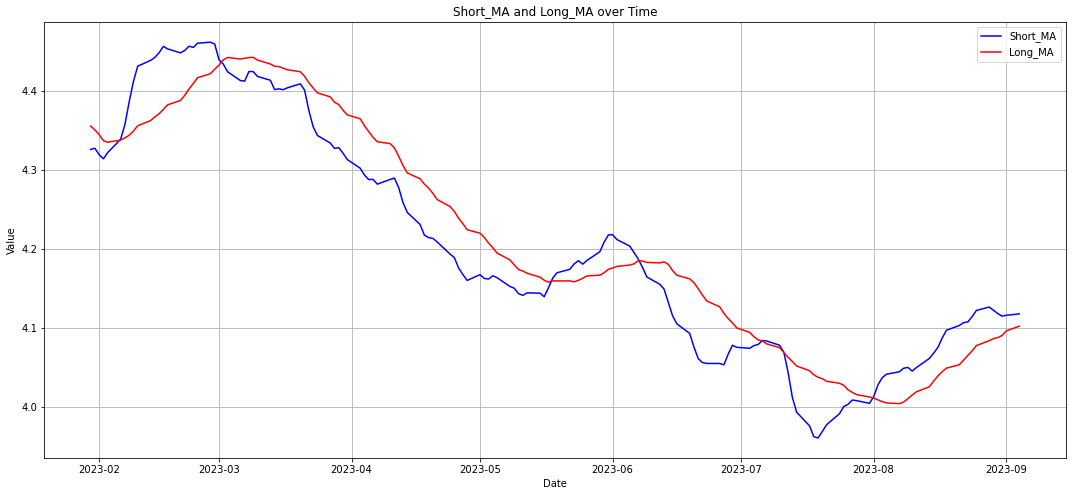

In [81]:
class SimpleMovingAverageStrategy(bt.Strategy):
    params = (
        ("short_period", 5),
        ("long_period", 20),
    )

    def __init__(self):
        self.short_ma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.short_period)
        self.long_ma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.long_period)
        self.crossover = bt.indicators.CrossOver(self.short_ma, self.long_ma)
        self.indicators_values = []

    def next(self):
        #print("Next method called!")
        #print("Short MA:", self.short_ma[0], "Long MA:", self.long_ma[0])
        #print(self.data.close[0])

        self.indicators_values.append([self.data.datetime.date(0), self.short_ma[0], self.long_ma[0]])
        if self.crossover > 0 and not self.position:  # Golden cross
            self.buy()
        elif self.crossover < 0 and self.position:  # Death cross
            self.close()

if __name__ == "__main__":
    # Wczytaj dane
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.iloc[::-1]  # Odwróć dane, aby najstarsze były na początku

    data = bt.feeds.PandasData(dataname=df)

    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(SimpleMovingAverageStrategy)

    # Uruchom strategię
    results = cerebro.run()

    # Pobierz instancję strategii
    strategy_instance = results[0]
    #cerebro.plot()
    # Sprawdź, czy mamy jakieś wartości wskaźników
    #print("Number of indicator values:", len(strategy_instance.indicators_values))

    # Zapisz wartości wskaźników do pliku
    pd.DataFrame(strategy_instance.indicators_values, columns=['Date', 'Short_MA', 'Long_MA']).to_csv('indicators_values.csv', index=False)

    

    # Wyodrębnij dane z listy indicators_values
    dates = [x[0] for x in strategy_instance.indicators_values]
    short_ma_values = [x[1] for x in strategy_instance.indicators_values]
    long_ma_values = [x[2] for x in strategy_instance.indicators_values]

    # Rysuj wykres
    plt.figure(figsize=(15, 7))
    plt.plot(dates, short_ma_values, label='Short_MA', color='blue')
    plt.plot(dates, long_ma_values, label='Long_MA', color='red')
    plt.title('Short_MA and Long_MA over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()